In [2]:
import elfi
import numpy as np
import pylab as plt
import scipy.stats as ss
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('../..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

# The problem

We begin with a very intuitive and easy toy example that will allow us to analytically compute the posterior. Our model will be $x \sim \mathcal{N}(\mu,\sigma^2)$, that is $x$ is distributed according to a Gaussian normal distribution with mean $\mu$ and variance $\sigma^2$. Let us assume that we have observed data $D=\{x_i|i=1,\ldots,30\}$ for which we know the variance $\sigma^2=1$ (for example from previous experiments or from literature)

# Generative Model

For the purpose of different priors, we assume that our generative model has the following shape: $g: x \sim \mathcal{N}(0.5, 1)$

In [3]:
np.random.seed(1335)

In [4]:
mu_t, sigma_t = 0.5, 1
mu_0, sigma_0 = 0, 0.2

N = 10

In [5]:
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
#os.makedirs(os.path.basename(os.path.join("data", "D")), exist_ok=True)
#pickle.dump(D, open(os.path.join("data", "D.pkl"), "wb"))
np.atleast_2d(D)

array([[-0.55286363,  0.73839318, -0.05872936,  2.57544769,  0.33974323,
        -0.7431614 , -1.14733082, -0.39151276,  0.7952032 ,  0.48591288]])

<IPython.core.display.Javascript object>


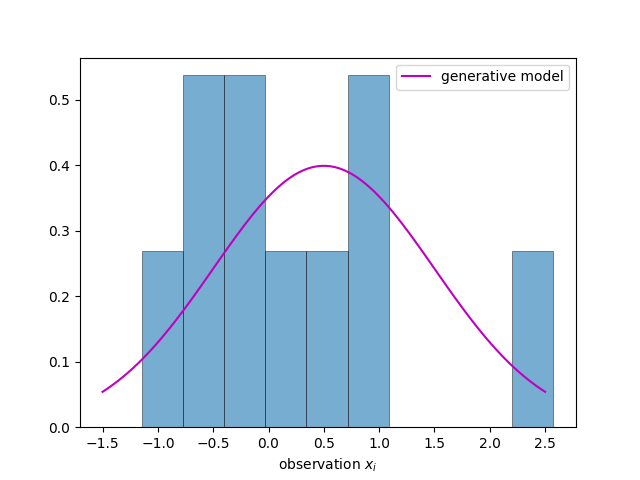

Text(0.5,0,'observation $x_i$')

In [6]:
plt.figure()
plt.hist(D, edgecolor="k", linewidth=0.5, color=["C0"], normed=True, alpha=0.6, histtype="bar", bins=N)
x = np.linspace(0.5-2, 0.5+2, 100)
y = ss.norm.pdf(x, mu_t, np.sqrt(sigma_t))
plt.plot(x,y, "-", color="m", label="generative model")
plt.legend()
plt.xlabel("observation $x_i$")

# Prior and Likelihood

We are interested in the probability distribution of the model parameter $\theta=\mu$ given our observed data, thus with Bayes' Theorem we can write

$p(\theta|D) \propto p(D|\theta) \cdot p(\theta).$

With the assumption of indentically and independently distributed (i.i.d.) drawn samples, the likelihood $p(D|\theta)$ can be written as the product of the likelihoods for each datum: $p(D|\theta) = \prod_{i=1}^N p(x_i|\theta) = (\cfrac{1}{2\pi\sigma²})^{\frac{n}{2}} \exp \left( -\cfrac{\sum_i^n (x_i - \mu)^2}{2\sigma^2} \right)$.

The prior represents our initial belief about the values $\theta=\mu$ might take. We will analyse the following three priors that represent very different initial belief sets.

$p(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0)$, with $\mu_0 = 0, \sigma_0^2 = 0.2$

<IPython.core.display.Javascript object>


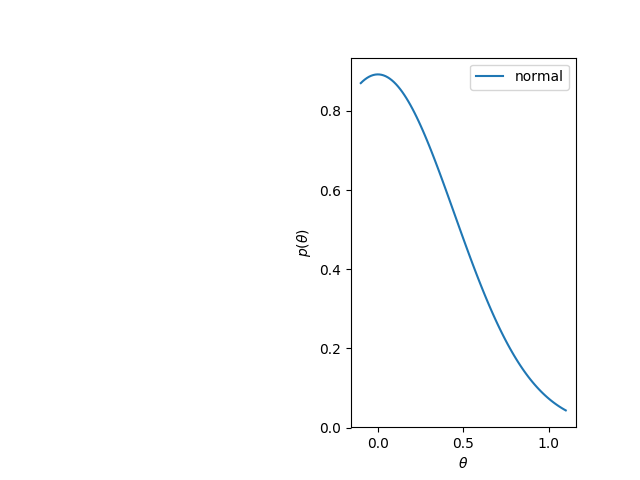

In [7]:
plt.figure()

# normal distributed prior
plt.subplot(1,2,2)
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
plt.plot(x,y, label="normal")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# Posterior

Now we look at the posterior. For each of the three priors, we can analytically calculate the posterior. Lets do this:

$\begin{align}
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot \mathcal{N}(\mu_0, \sigma^2_0) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \cfrac{1}{N\sigma_0^2 + \sigma^2} \cdot (\sigma^2\mu_0 + N\sigma_0^2\mu), \sigma^2_N = \cfrac{\sigma^2\sigma^2_0}{N\sigma^2_0 + \sigma^2} \\
\end{align}
$

In [8]:
def likelihood(mus):
    ret = np.zeros(mus.shape[0])
    for i, mu in enumerate(mus):
        ret[i] = ss.norm(mu, sigma_t / N).pdf(np.mean(D))
    return ret

def posterior(mus):
    sigma_N = 1 / (N/sigma_t + 1/sigma_0)
    mu_N = sigma_N * (mu_0 / sigma_0 + N * np.mean(D) / sigma_t)
    
    ret = np.zeros(mus.shape[0])
    for i, mu in enumerate(mus):
        ret[i] = ss.norm(mu_N, np.sqrt(sigma_N)).pdf(mu)
    return ret

<IPython.core.display.Javascript object>


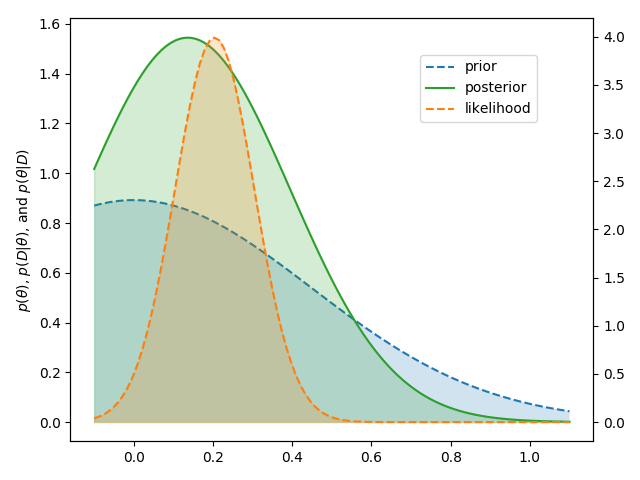

In [9]:
# normal distributed prior
fig, ax = plt.subplots()
thetas = np.linspace(-0.1, 1.1, 100)
prior = ss.norm.pdf(thetas, mu_0, np.sqrt(sigma_0))
ax.fill_between(thetas, y1=y, y2=0, alpha=0.2, zorder=0)
ax.plot(thetas,y, "--", label="prior", color="C0", zorder=0)

ax2 = ax.twinx()
like = likelihood(thetas)
ax2.fill_between(thetas, y1=like, y2=0, alpha=0.2, color="C1", zorder=1)
ax2.plot(thetas, like, "--", label="likelihood", color="C1", zorder=1)

ax.fill_between(thetas, y1=posterior(thetas), y2=0, alpha=0.2, color="C2", zorder=30)
ax.plot(thetas, posterior(thetas), label="posterior", color="C2", zorder=30)

plt.xlabel(r"$\theta$")
ax.set_ylabel(r"$p(\theta)$, $p(D|\theta)$, and $p(\theta|D)$")

fig.legend(bbox_to_anchor=(0.85, 0.9))
plt.tight_layout()

plt.savefig('ex01_model.pdf', bbox_inches='tight')

# ABC

In [21]:
prior = pyabc.Prior("normal", mu_0, np.sqrt(sigma_0), name=r"$\mu$")

In [11]:
def simulator_mu(mu, batch_size=1, random_state=None):
    return ss.norm(loc=mu, scale=np.sqrt(sigma_t)).rvs((batch_size, N))

simulator_mu(0)

array([[-1.36402709, -0.79474783, -1.07291723,  0.21274463, -0.58600603,
        -0.97971222,  1.18346127,  0.22661906,  0.48866767, -0.03059361]])

In [12]:
def mean(x):
    return np.mean(np.atleast_2d(x), axis=1)

## Show correctness for three classical ABC sampler

In [13]:
D = np.atleast_2d(D)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
mcmc = pyabc.MCMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
smc = pyabc.SMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)

In [14]:
rej.sample(nr_samples=2000, threshold=0.02)

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:   2000 - Threshold: 0.0200 - Iterations:      74000 - Acceptance rate: 0.027027 - Time:    48.80 s


In [15]:
mcmc.sample(nr_samples=2000, threshold=0.02, step_size=[0.05])

MCMC sampler started with threshold: 0.02 and number of samples: 2000
Samples:   2000 - Threshold: 0.0200 - Iterations:      59633 - Acceptance rate: 0.033538 - Time:   155.90 s


In [16]:
smc.sample(nr_samples=2000, thresholds=np.linspace(0.1, 0.02, 6))

SMC sampler started with thresholds: [ 0.1    0.084  0.068  0.052  0.036  0.02 ] and number of samples: 2000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
starting iteration[ 4 ]
Iteration 4 completed
starting iteration[ 5 ]
Iteration 5 completed
Samples:   2000 - Thresholds: 0.02 - Iterations:     190383 - Acceptance rate: 0.010505 - Time:   322.07 s


<IPython.core.display.Javascript object>


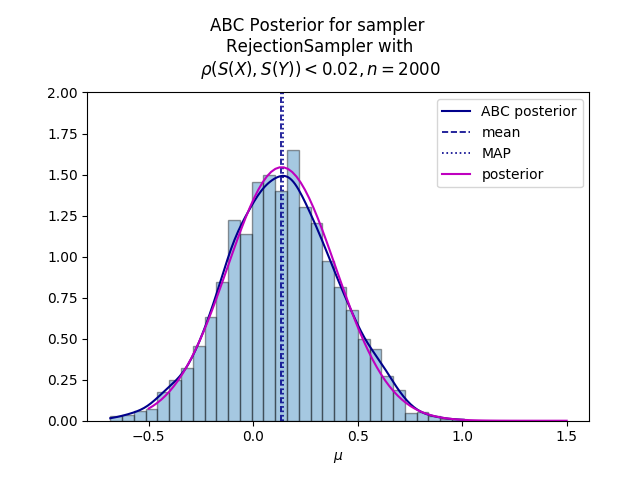

<IPython.core.display.Javascript object>


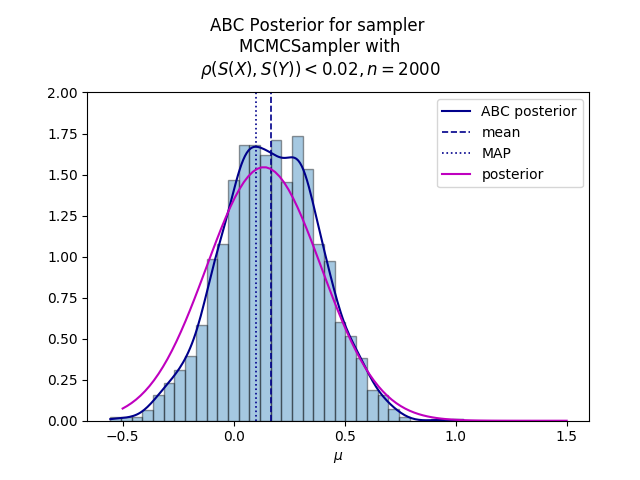

<IPython.core.display.Javascript object>


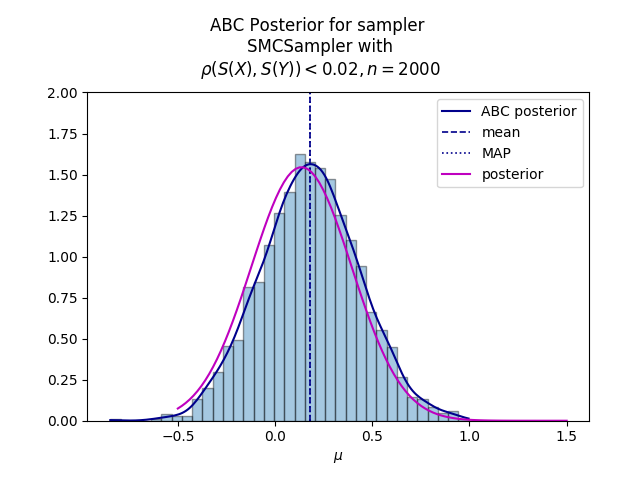

In [18]:
fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])
x = np.linspace(mu_t-1, mu_t+1, 100)

prior = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
like = likelihood(x)

plt.plot(x, posterior(x), "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_10.pdf', bbox_inches='tight')

fig = plot_marginals(mcmc, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, posterior(x), "m", label="posterior")
plt.legend()

plt.savefig('ex01_mcmc_n_2000_e_0_02_s_0_05_D_10.pdf', bbox_inches='tight')

fig = plot_marginals(smc, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, posterior(x), "m", label="posterior")
plt.legend()

plt.savefig('ex01_smc_n_2000_e_0_02_es_6_D_10.pdf', bbox_inches='tight')

# Comparison with ELFI

In [13]:
mu = elfi.Prior('normal', mu_0, np.sqrt(sigma_0))

# Add the simulator node and observed data to the model
sim = elfi.Simulator(simulator_mu, mu, observed=np.atleast_2d(D))

# Add summary statistics to the model
S1 = elfi.Summary(mean, sim)

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
d = elfi.Distance('euclidean', S1)

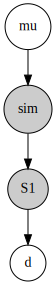

In [14]:
# Plot the complete model (requires graphviz)
elfi.draw(d)

In [15]:
elfi_smc = elfi.SMC(d, batch_size=1, seed=30052017)
elfi_smc = smc.sample(2000, np.linspace(0.1,0.03,4))

elfi_smc.summary()

Method: SMC
Number of samples: 2000
Number of simulations: 213160
Threshold: 0.00998
Sample means: mu: 0.246

Method: SMC
Number of samples: 2000
Number of simulations: 213160
Threshold: 0.00998
Sample means: mu: 0.246
None


<IPython.core.display.Javascript object>


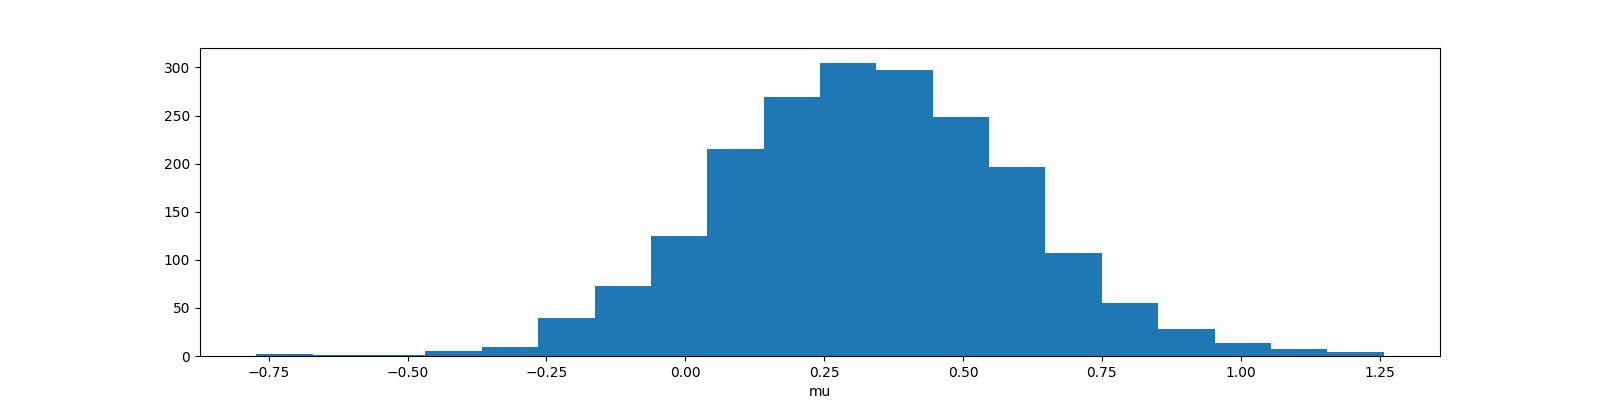

In [17]:
elfi_smc.plot_marginals()

## Analyze influence of parameter

### Influence of epsilon

Rejection sampler started with threshold: 1 and number of samples: 2000
Samples:   2000 - Threshold: 1.0000 - Iterations:       3000 - Acceptance rate: 0.666667 - Time:     2.00 s


<IPython.core.display.Javascript object>


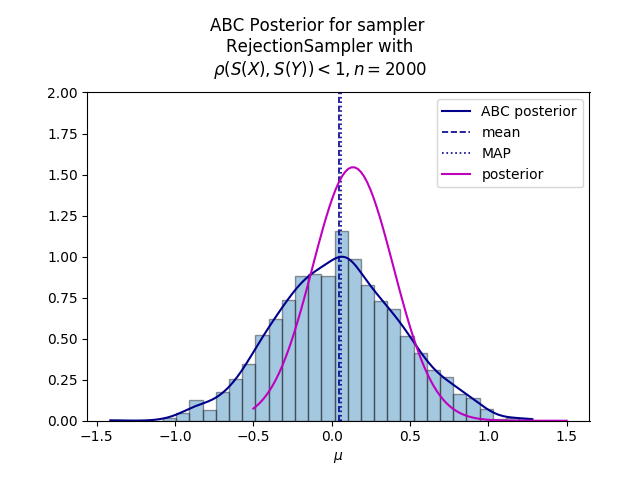

Rejection sampler started with threshold: 0.5 and number of samples: 2000
Samples:   2000 - Threshold: 0.5000 - Iterations:       4000 - Acceptance rate: 0.500000 - Time:     2.96 s


<IPython.core.display.Javascript object>


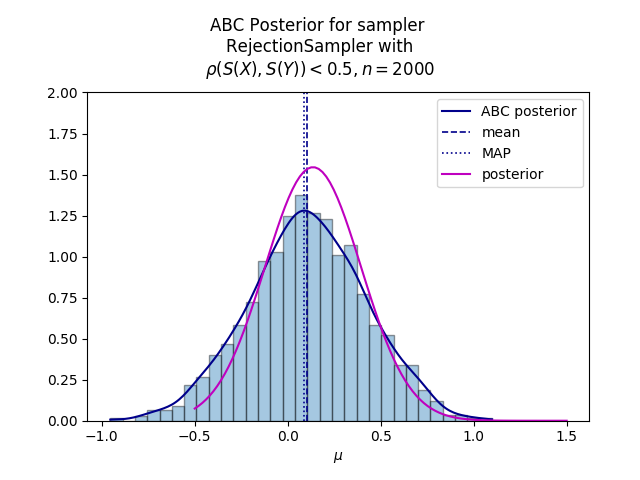

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:   2000 - Threshold: 0.0200 - Iterations:      76000 - Acceptance rate: 0.026316 - Time:    48.38 s


<IPython.core.display.Javascript object>


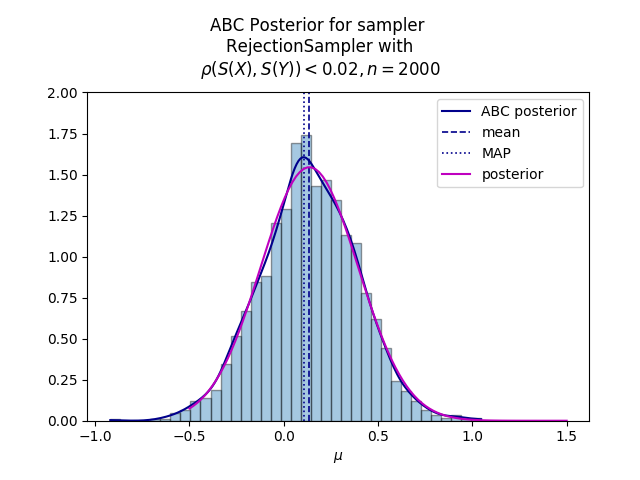

In [19]:
rej.sample(nr_samples=2000, threshold=1)

fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])
x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_1_D_10.pdf', bbox_inches='tight')

rej.sample(nr_samples=2000, threshold=0.5)

fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_5_D_10.pdf', bbox_inches='tight')

rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True}, ylim=[0, 2])

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_10.pdf', bbox_inches='tight')


### Influence of samples

Rejection sampler started with threshold: 0.02 and number of samples: 100
Samples:    100 - Threshold: 0.0200 - Iterations:       4000 - Acceptance rate: 0.025000 - Time:     2.81 s


<IPython.core.display.Javascript object>


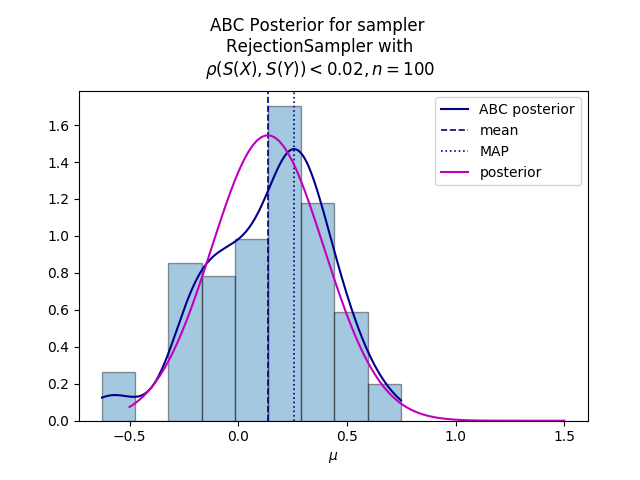

Rejection sampler started with threshold: 0.02 and number of samples: 1000
Samples:   1000 - Threshold: 0.0200 - Iterations:      38000 - Acceptance rate: 0.026316 - Time:    29.34 s


<IPython.core.display.Javascript object>


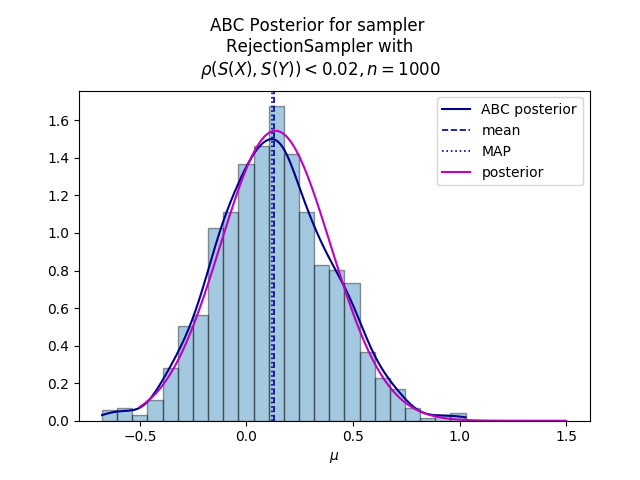

Rejection sampler started with threshold: 0.02 and number of samples: 10000
Samples:  10000 - Threshold: 0.0200 - Iterations:     368000 - Acceptance rate: 0.027174 - Time:   314.97 s


<IPython.core.display.Javascript object>


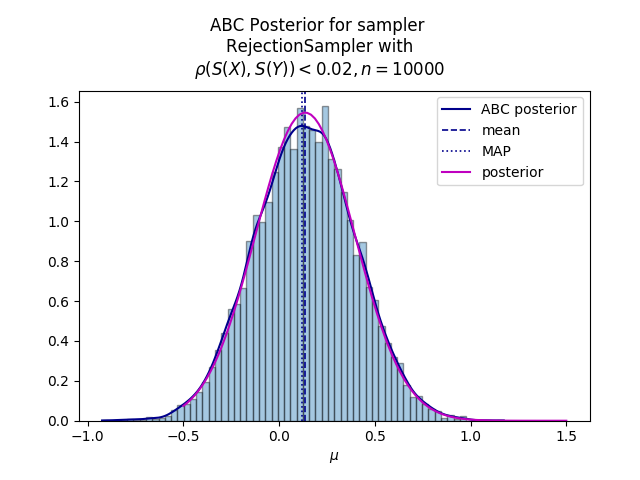

In [51]:
rej.sample(nr_samples=100, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})
x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_100_e_0_02_D_10.pdf', bbox_inches='tight')


rej.sample(nr_samples=1000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_1000_e_0_02_D_10.pdf', bbox_inches='tight')

rej.sample(nr_samples=10000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_10000_e_0_02_D_10.pdf', bbox_inches='tight')


### Influence of amount of observational data

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:   2000 - Threshold: 0.0200 - Iterations:     139000 - Acceptance rate: 0.014388 - Time:   222.00 s


<IPython.core.display.Javascript object>


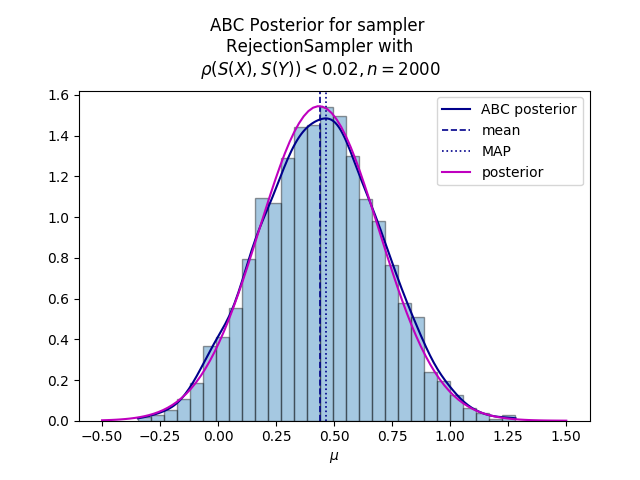

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:   2000 - Threshold: 0.0200 - Iterations:      79000 - Acceptance rate: 0.025316 - Time:   184.55 s


<IPython.core.display.Javascript object>


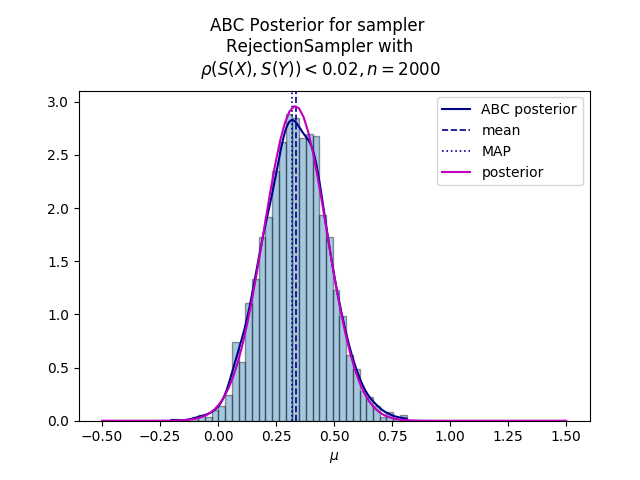

Rejection sampler started with threshold: 0.02 and number of samples: 2000
Samples:   2000 - Threshold: 0.0200 - Iterations:      76000 - Acceptance rate: 0.026316 - Time:   136.45 s


<IPython.core.display.Javascript object>


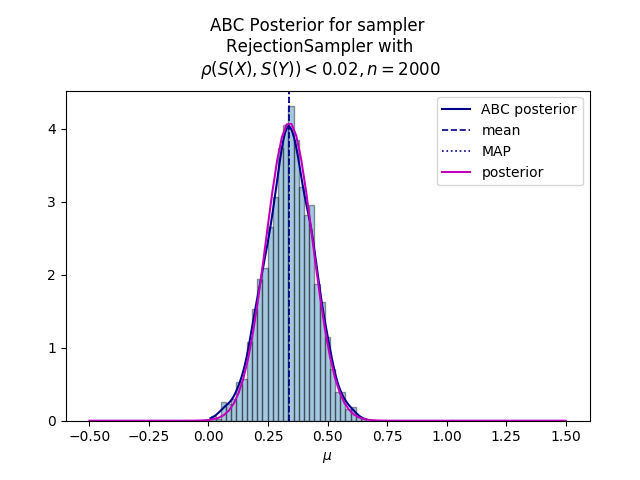

In [23]:
N = 10
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_10.pdf', bbox_inches='tight')

N = 50
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)

plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_50.pdf', bbox_inches='tight')

N = 100
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
rej.sample(nr_samples=2000, threshold=0.02)

fig = plot_marginals(rej, hist_kws = {'normed': True})

x = np.linspace(mu_t-1, mu_t+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

plt.savefig('ex01_rej_n_2000_e_0_02_D_100.pdf', bbox_inches='tight')